<a href="https://colab.research.google.com/github/Sejmou/ml-ex3/blob/master/notebooks/LeNet5_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # unfortunately, we cannot import our helper scripts directly on Google Colab as other files from our repo are not accessible
  # we have to clone our GitHub repo to fetch the helper scripts and add the script folder of cloned repo to the syspath

  print('Notebook running on Google Colab')
  repo_path = './ml-ex3'
  repo_git_url = 'https://github.com/Sejmou/ml-ex3.git'

  import subprocess
  import sys

  def install(package):#https://stackoverflow.com/a/50255019/13727176
    print(f'Installing {package} using pip')
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
  
  if 'git' not in sys.modules:
    install('GitPython')
  
  from git import Repo

  if os.path.exists(repo_path): # already cloned -> pull latest changes
    print('pulling from our git repo to get latest version of helper scripts')
    repo = Repo(repo_path)
    o = repo.remotes.origin
    o.pull()
    print('pulled successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')
    import importlib
    import helper_scripts
    importlib.reload(helper_scripts)
    print('reloaded helper_scripts module')
  else:
    print('cloning our git repo to get helper scripts')
    Repo.clone_from(repo_git_url, repo_path)
    print('cloned successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')

  from google.colab import drive
  drive.mount('/content/drive')
  root_log_dir = f'/content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'#pick drive folder that suits you
else:
  root_log_dir = f'../model_fit_results/CIFAR-10/LeNet/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'

Notebook running on Google Colab
Installing GitPython using pip
cloning our git repo to get helper scripts
cloned successfully
appended helper_scripts module to sys.path
Mounted at /content/drive


# Training and Evaluating LeNet-5 on the CIFAR-10 dataset

## Loading the data

LeNet takes an image of shape 32x32x1 in the input layer (i.e., the images should all be grayscale). Furthermore, the input image intensity values should be normalized. We get the images in the desired format from our data loader:

In [3]:
from helper_scripts.data_loaders import CIFAR10Loader

data_loader = CIFAR10Loader('.data/')

X_train, X_val, X_test, y_train, y_val, y_test = data_loader.get_processed_imgs(target_width=32, target_height=32,
                                                        normalize=True, convert_to_grayscale=True)

Finished downloading required files for CIFAR-10 dataset
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


Let's have a quick look at what the data we got back looks like:

In [4]:
from helper_scripts.data_exploration import print_dataset_summary, show_img

print_dataset_summary(data=(X_train, X_val, X_test, y_train, y_val, y_test), dataset_name='CIFAR-10')


--- Checking loaded CIFAR-10 data ---
Data types
X_train: <class 'numpy.ndarray'>
X_val: <class 'numpy.ndarray'>
X_test: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>
y_val: <class 'numpy.ndarray'>
y_test: <class 'numpy.ndarray'>

Data shapes
X_train: (35000, 32, 32)
X_val: (15000, 32, 32)
X_test: (10000, 32, 32)
y_train: (35000,)
y_val: (15000,)
y_test: (10000,)

Image stats:
shape: (60000, 32, 32)
Max value across all images and channels: 0.9998999999999999
Min value across all images and channels: 0.0
Split sizes:
 train size: 35000
validation size: 15000
test size: 10000
Total dataset size: 60000

Train/Val/Test ratio: 0.58/0.25/0.17
Train/Val ratio:0.7/0.3
(Train+Val)/Test ratio:0.83/0.17


We notice that y_train, y_val, and y_test are in the wrong shape to be used by Keras classifiers. We need to one-hot-encode them:

In [5]:
from tensorflow.keras.utils import to_categorical 

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

Let's also have a look at an example image from the train, test, and validation datasets:

In [6]:
X_train[3].min()

0.10158745098039217

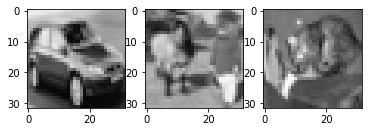

In [7]:
fig, ax = plt.subplots(1, 3)

for i, split in enumerate([X_train, X_val, X_test]):
  show_img(split[0], ax=ax[i], val_range_min=0, val_range_max=1)

Finally, let's remind ourselves what classes the dataset contains:

In [8]:
data_loader.text_label_dict

{0: 'Airplane',
 1: 'Automobile',
 2: 'Bird',
 3: 'Cat',
 4: 'Deer',
 5: 'Dog',
 6: 'Frog',
 7: 'Horse',
 8: 'Ship',
 9: 'Truck'}

## Defining the Model (based on [this](https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086)):

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers.convolutional import AveragePooling2D

def LeNetModel(num_classes):
  model = Sequential()

  model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
  model.add(AveragePooling2D())

  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(AveragePooling2D())

  model.add(Flatten())

  model.add(Dense(units=120, activation='relu'))

  model.add(Dense(units=84, activation='relu'))

  model.add(Dense(units=num_classes, activation = 'softmax'))
  return model

### Fitting w/o Data Augmentation:

In [10]:
loss = 'binary_crossentropy' 
optimizer = 'sgd'
num_classes = data_loader.number_of_classes

model = LeNetModel(num_classes)
model.compile(loss=loss , optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [11]:
epochs = 300
batch_size=32

### Adding callbacks

We will use three callbacks: one for storing the best model weights, one custom callback for measuring the fit time, and one for logging the training process to TensorBoard.

In [12]:
from keras.callbacks import ModelCheckpoint

log_dir = os.path.join(root_log_dir, 'no_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)




In [13]:
from helper_scripts.deep_learning import TimeHistory
time_cb = TimeHistory()

In [14]:
from keras.callbacks import TensorBoard

tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

In [15]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data= (X_val, y_val),
    callbacks=[checkpoint_cb, time_cb, tensorboard_cb]
)

Epoch 1/300
1094/1094 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.1361
Epoch 1: val_accuracy improved from -inf to 0.16860, saving model to /content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
1094/1094 [==============================] - 20s 6ms/step - loss: 0.3666 - accuracy: 0.1361 - val_loss: 0.3250 - val_accuracy: 0.1686
Epoch 2/300
1085/1094 [============================>.] - ETA: 0s - loss: 0.3235 - accuracy: 0.1727
Epoch 2: val_accuracy improved from 0.16860 to 0.18273, saving model to /content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
1094/1094 [==============================] - 6s 6ms/step - loss: 0.3234 - accuracy: 0.1730 - val_loss: 0.3218 - val_accuracy: 0.1827
Epoch 3/300
1093/1094 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.1818
Epoch 3: val_accuracy did not improve from 0.18273
1094/1094 [=========================

In [16]:
import time

time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))}')

Total fit time was 00:35:36


In [17]:
print(f'{checkpoint_path}')

/content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5


In [18]:
# load optimal model
model.load_weights(checkpoint_path)

scores = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.2226 - accuracy: 0.5124


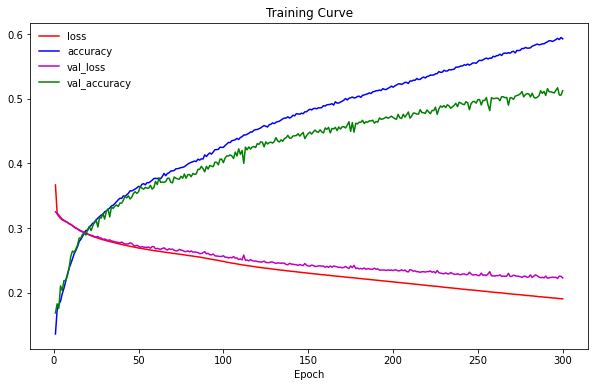

In [21]:
from helper_scripts.deep_learning import plot_loss_and_acc

plot_loss_and_acc(history.history, epochs)
model.save(os.path.join(log_dir, 'Model.h5'))

### Fitting with Data Augmentation:

We can use Keras' `ImageDataGenerator`:

In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
np.random.seed(0)

In [23]:
loss = 'binary_crossentropy' 
optimizer = 'sgd' 

model = LeNetModel(num_classes)
model.compile(loss=loss , optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [27]:
log_dir = os.path.join(root_log_dir, 'with_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [25]:
time_cb = TimeHistory()

In [26]:
tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=datagen.flow(X_val, y_val, batch_size=batch_size),
                    workers=4,
                    epochs=epochs, callbacks=[checkpoint_cb, time_cb, tensorboard_cb])

In [ ]:
time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))} seconds')

In [ ]:
# load optimal model
model.load_weights(checkpoint_path)

scores = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
plot_loss_and_acc(history.history)
model.save(os.path.join(log_dir, 'Model.h5')